In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [ ]:
#read in the Reddit Posts
nashville_posts =  pd.read_csv('nashvillesc_posts.csv')
nashville_posts.columns

Index(['Unnamed: 0', 'Post Title', 'Post ID', 'Author', 'Score', 'Comments',
       'Created', 'Post URL', 'Text'],
      dtype='object')

In [ ]:
#read in the Reddit Comments
nashville_comments = pd.read_csv('nashvillesc_comments.csv')
nashville_comments = nashville_comments.dropna(subset="Comment Body")
nashville_comments.columns

Index(['Unnamed: 0', 'Post ID', 'Comment Author', 'Comment Body',
       'Comment Score', 'Created', 'Sentiment'],
      dtype='object')

In [ ]:
### Topic Modeling ###

#Vectorize and get rid of stop words
vectorizer = CountVectorizer(stop_words="english", max_features=5000)
comment_matrix = vectorizer.fit_transform(nashville_comments["Comment Body"])

#LDA    
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda_output = lda.fit_transform(comment_matrix)  

topic_word_contributions = {}
for idx, topic in enumerate(lda.components_):
    words = vectorizer.get_feature_names_out()
    contributions = topic / topic.sum()  # Normalize contributions
    topic_word_contributions[idx] = dict(zip(words, contributions))
    top_words = sorted(topic_word_contributions[idx].items(), key=lambda x: x[1], reverse=True)[:10]
    print(f"Topic {idx}:")
    for word, contribution in top_words:
        print(f"  {word}: {contribution:.4f}")

#append toppic and probabiility to df
nashville_comments["Dominant Topic"] = lda_output.argmax(axis=1)
nashville_comments["Dominant Topic Probability"] = lda_output.max(axis=1)

Topic 0:
  game: 0.0151
  team: 0.0110
  just: 0.0109
  goal: 0.0100
  ve: 0.0093
  messi: 0.0085
  season: 0.0082
  miami: 0.0072
  fucking: 0.0071
  mls: 0.0068
Topic 1:
  tickets: 0.0220
  season: 0.0171
  game: 0.0137
  ticket: 0.0125
  section: 0.0112
  just: 0.0096
  cup: 0.0093
  club: 0.0076
  seats: 0.0074
  think: 0.0069
Topic 2:
  nashville: 0.0175
  like: 0.0157
  game: 0.0138
  don: 0.0118
  just: 0.0100
  team: 0.0084
  fan: 0.0083
  fans: 0.0083
  stadium: 0.0072
  club: 0.0069
Topic 3:
  removed: 0.0360
  nashvillesc: 0.0296
  comment: 0.0262
  contact: 0.0245
  karma: 0.0214
  thanks: 0.0194
  message: 0.0192
  questions: 0.0180
  automatically: 0.0175
  action: 0.0174
Topic 4:
  just: 0.0146
  team: 0.0146
  like: 0.0143
  good: 0.0137
  think: 0.0117
  gary: 0.0115
  players: 0.0107
  don: 0.0094
  hany: 0.0091
  play: 0.0087


#### Topic Zero
- Discussion around Lionel Messi's match against Nashville SC, general match performance analysis as well
#### Topic One
- Discussion around ticketing, pricing, and attendance. (Will focus on this)
#### Topic Two
- Fan engagement, stadium experiences, and team performance
#### Topic Three
- Comments or posts being removed, likely due to subreddit moderation
#### Topic Four
- Discussions around players and team strategy

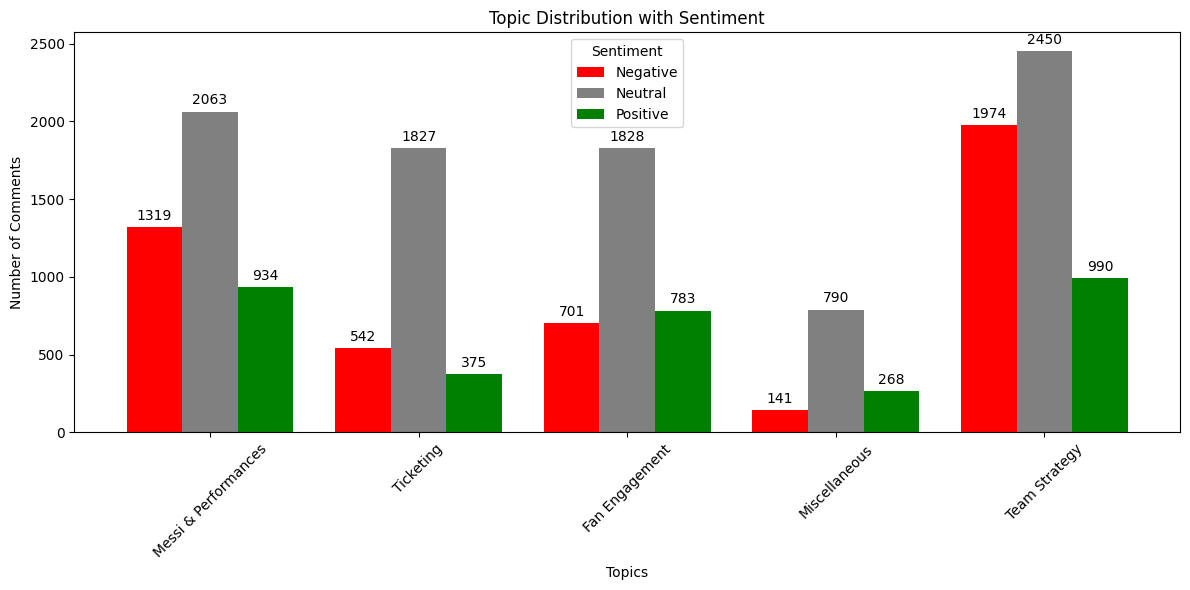

In [13]:
#Topic titles from LDA 
Topics = ['Messi & Performances', 'Ticketing', 'Fan Engagement', 'Miscellaneous', 'Team Strategy']

#sentimentys by topic 
topic_sentiment_counts = (
    nashville_comments.groupby(["Dominant Topic", "Sentiment"])
    .size()
    .unstack(fill_value=0))

### Plot ###
ax = topic_sentiment_counts.plot(
    kind="bar",
    figsize=(12, 6),
    color=["red", "gray", "green"], 
    width=0.8
)

# Add labels on bars
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', fontsize=10, padding=3)

# Formatting
plt.xlabel("Topics")
plt.ylabel("Number of Comments")
plt.title("Topic Distribution with Sentiment")
plt.xticks(
    ticks=range(len(topic_sentiment_counts.index)),
    labels=Topics,
    rotation=45
)
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()


In [12]:
#Printed df 
topic_sentiment_counts

Sentiment       Negative  Neutral  Positive
Dominant Topic                             
0                   1319     2063       934
1                    542     1827       375
2                    701     1828       783
3                    141      790       268
4                   1974     2450       990

In [ ]:
###Focus attention on ticketing comments ###

topic_tickets = nashville_comments[nashville_comments['Dominant Topic']==1]
topic_tickets = topic_tickets[topic_tickets['Sentiment']== 'Negative'].sort_values(by = "Comment Score", ascending= False)
topic_tickets.head()

### Look at individual comments if needed here ###
for comment in topic_tickets['Comment Body']:
    print(comment)

Ingram needs to go the Arthur Blank route and fucking lower concessions if they want to increase ticket prices
Just another reason why I won’t buy season tickets and will wait to buy a $10 ticket on game day
Travesty we let him retire in Atlanta.
I think general opinion (here at least) is that the song sucks
Not even a request for free beer? Lame
This would have been much a nicer gift than another shitty scarf for season ticket members
Yeahhhh this is one of the things I don't tip for, it's 2 seconds of interaction and as you said the beer is already 16 bucks.
Yeah, I feel like NSC's strategy has always been low ticket prices made up for by $13 beers and $12 burgers. They're picking the wrong time to get greedy though.
Huge error in judgement by NSC brass. One grave enough that I am not renewing season tickets next season. The thought of a half-filled Geodis with folks screaming for Messi instead of the Boys in Gold really pisses me off.
Who cares about leagues cup. Have him rest for N

In [ ]:
#I would like to see the posts contributing the most negative sentiment and why
merged_pc = pd.merge(
    nashville_posts,
    topic_tickets,
    on='Post ID')

total_comments_per_post = merged_pc.groupby('Post ID')['Comment Body'].count()
average_comment_score = merged_pc.groupby('Post ID')['Comment Score'].mean()
negative_comments_per_post = merged_pc[merged_pc['Sentiment'] == 'Negative'].groupby('Post ID')['Comment Body'].count()
negative_comment_ratio = negative_comments_per_post / total_comments_per_post
negative_comment_ratio = negative_comment_ratio.reset_index(name='Negative Comment Ratio')
negative_comment_ratio = negative_comment_ratio.dropna()
negative_comment_ratio = negative_comment_ratio.sort_values(by = "Negative Comment Ratio", ascending= False)

negative_comment_ratio = pd.merge(
    negative_comment_ratio,
    total_comments_per_post,
    on='Post ID')

negative_comment_ratio = pd.merge(
    negative_comment_ratio,
    average_comment_score,
    on='Post ID')

badpoststickets = negative_comment_ratio[negative_comment_ratio['Comment Body']>5].sort_values(by= ["Negative Comment Ratio", "Comment Score"],ascending= False)
badpoststickets[0:3]

###1g21isy seemed to drive people crazy###
### people felt four times as strongly than other negative ticketing complaints ###

Post ID  Negative Comment Ratio  Comment Body  Comment Score
58   1g21isy                     1.0             9      25.888889
101  1b85j55                     1.0            18       6.888889
41   1blwx2b                     1.0             6       6.666667

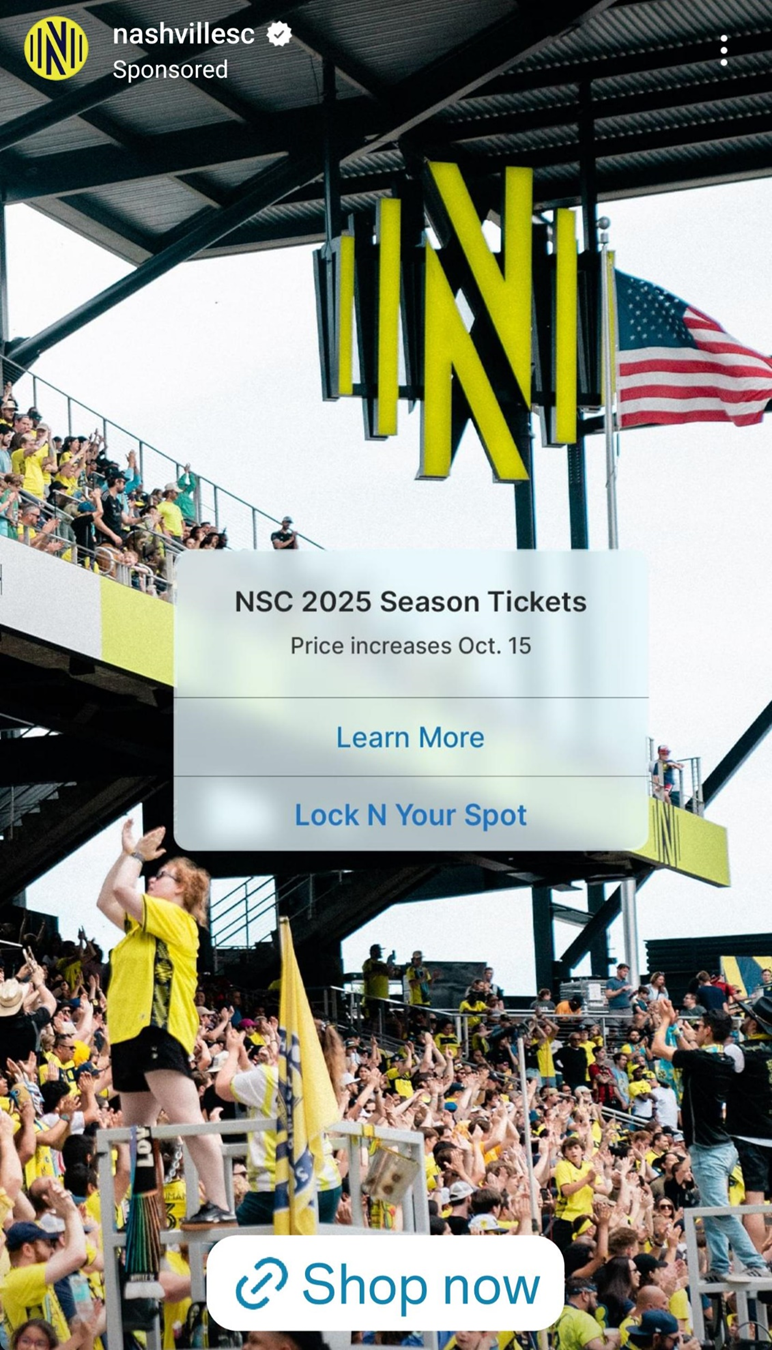

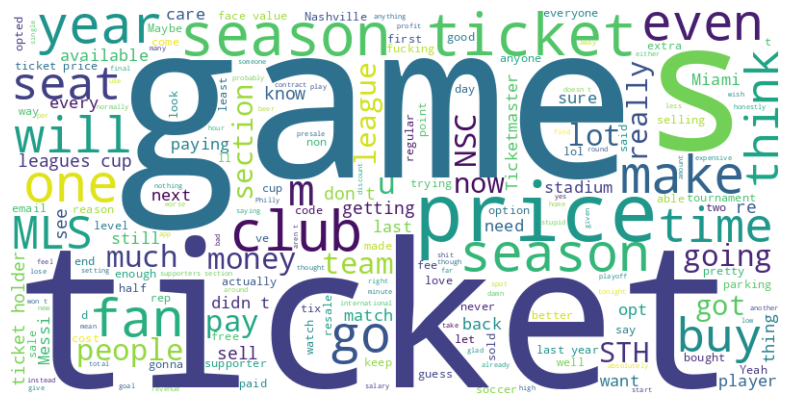

In [ ]:
#Word cloud for EDA of Topic 1 
text = " ".join(topic_tickets["Comment Body"])
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)

#plot 
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [9]:
### Popular comments that could drive potential business strategy ###
print("---Gameday Inconviniences and Costs---")
print(topic_tickets.iloc[0]['Comment Body']) #lower concession prices, subsidized by higher ticket prices (in line with ATL)
print(topic_tickets.iloc[12]['Comment Body']) # prevent gameday inconviniences

print("---Combat Event Day Price Phenomena---")
print(topic_tickets.iloc[1]['Comment Body']) #combat demand day of event, make it rational to consumer to pay surplus in lumpsum
print(topic_tickets.iloc[42]['Comment Body']) #combat demand day of event, make it rational to consumer to pay surplus in lumpsum

print("---Better season ticket gift---")
print(topic_tickets.iloc[5]['Comment Body']) # better season ticket gift
print(topic_tickets.iloc[255]['Comment Body']) # better season ticket gift

#regEx searches if needed
# topic_tickets[topic_tickets["Comment Body"].str.contains(r"\bscarf?\b", case=False, na=False)]

---Gameday Inconviniences and Costs---
Ingram needs to go the Arthur Blank route and fucking lower concessions if they want to increase ticket prices
Parking for any game is a dumpster fire, so yes
---Combat Event Day Price Phenomena---
Just another reason why I won’t buy season tickets and will wait to buy a $10 ticket on game day
I canceled mine this year. I think I was able to sell mine for face value one or two times max. No reason to buy them when I don’t go to half of the games and I can buy them on game day for half the price.
---Better season ticket gift---
This would have been much a nicer gift than another shitty scarf for season ticket members
I wish they would do something besides a scarf every year


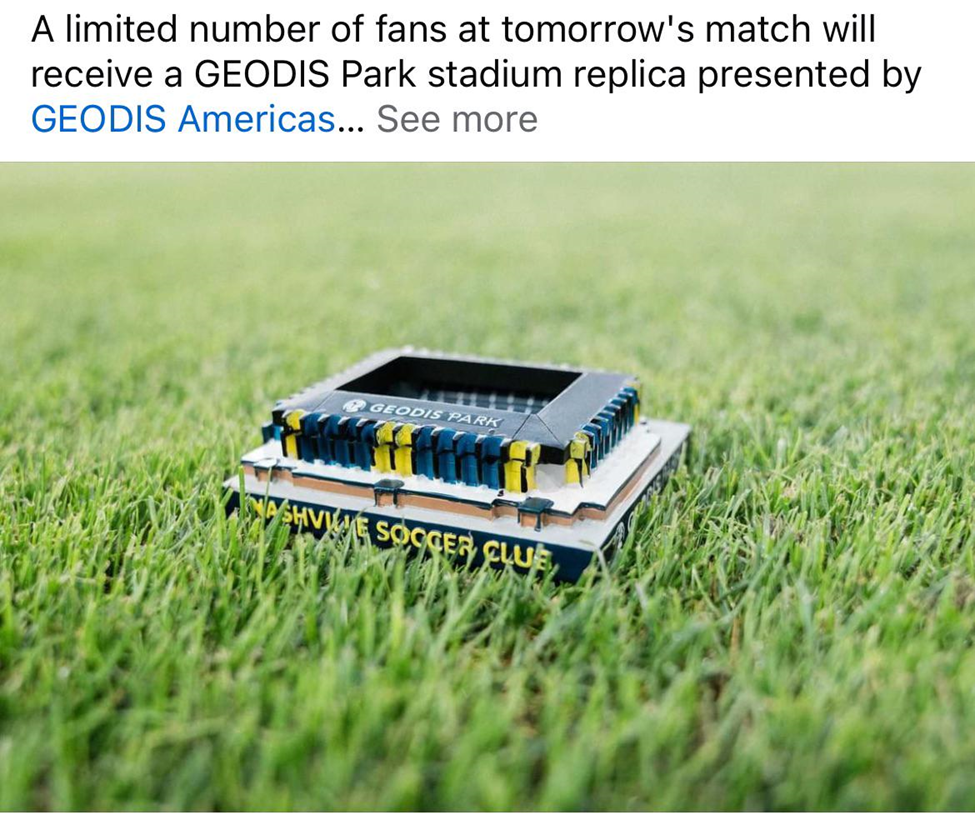

In [10]:
### Unrelated, but the fans don't seem to like the post game song ###
print(topic_tickets.iloc[3])

Unnamed: 0                                                                 5012
Post ID                                                                 1ct2qva
Comment Author                                                    volcanicglass
Comment Body                  I think general opinion (here at least) is tha...
Comment Score                                                                44
Created                                                     2024-05-16 03:08:50
Sentiment                                                              Negative
Dominant Topic                                                                1
Dominant Topic Probability                                             0.588212
Name: 5012, dtype: object


In [11]:
### Instead of using LDA, potentially check out posts using regExes ###

# regextix = nashville_comments[nashville_comments["Comment Body"].str.contains(r"\btickets?\b", case=False, na=False)]

# for comment in regextix['Comment Body']:
#     print(comment)